# Etiquetado de datos

La etiqueta es la variable que se requiere, predigan los modelos. Esta no viene de manera explícita indicada en los datos. Con la información del Data Mart se extraerá la etiqueta. Este proceso esta en la ingeniería de características dado que se generará una nueva, de significativa importancia. De esta también dependerá la agregación de la característica Fresnel.

In [1]:
#Importando librerías
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from fefunctions import *
import random
import json
import math
import sys
sys.path.append('../')
sys.path.append('../../')
from sklearn.neighbors import NearestNeighbors
import Python.Private.constants as private_constants
from Python.Preprocessing.funcs import  *
from Python.Style.styles import  *
import warnings
from Resources.mlTracker import *
#Entrenando modelo KNN para imputar vecinos
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
#Basic config
warnings.filterwarnings("ignore")
pd.set_option('display.float_format',  '{:,.8f}'.format)
#Utilizando diseño base 1
plt.style.use('../../Python/Style/style1.mplstyle')

In [3]:
#Colores base
#Diseño base
mClr = designC['cs']
mClr_d2 = plt.get_cmap('cs-d')(2)
sClr1 = designC['nr']
sClr1_d2 = plt.get_cmap('nr-d')(2)
sClr3 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr4 = designC['vr']
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

## Tratando variables de interés para etiquetado

In [4]:
# Leyendo datos equipos
mg_df = pd.read_parquet("../../Data/DataMart/Base/mg_treated_final.parquet")
mr_df = pd.read_parquet("../../Data/DataMart/Base/mr_treated_final.parquet")
mc_df = pd.read_parquet("../../Data/DataMart/Base/mc_treated_final.parquet")

In [5]:
#Vacíos en no communicating days
mg_ncd_empty = len(mg_df[mg_df['NoCommunicatingDays'].isna()])
mr_ncd_empty = len(mr_df[mr_df['NoCommunicatingDays'].isna()])
mc_ncd_empty = len(mc_df[mc_df['NoCommunicatingDays'].isna()])
print(f"mg: {mg_ncd_empty} mr: {mr_ncd_empty} mc: {mc_ncd_empty}")

mg: 0 mr: 0 mc: 31


In [ ]:
#Seleccionando vacíos en NCD
mc_ncd_df = mc_df[mc_df['NoCommunicatingDays'].isna()]
mc_ncd_df.to_csv("../../Data/DataMart/temp/mc_ncd_empty.csv", index=False)
mc_ncd_df.head()

In [7]:
#Vacíos en LastPacketReceived
mg_lpr_empty = len(mg_df[mg_df['LastPacketReceived'].isna()])
mr_lpr_empty = len(mr_df[mr_df['LastPacketReceived'].isna()])
mc_lpr_empty = len(mc_df[mc_df['LastPacketReceived'].isna()])
print(f"mg: {mg_lpr_empty} mr: {mr_lpr_empty} mc: {mc_lpr_empty}")

mg: 0 mr: 0 mc: 31


In [8]:
#Vacíos en LastStatusChanged
mg_lsc_empty = len(mg_df[mg_df['LastStatusChanged'].isna()])
mr_lsc_empty = len(mr_df[mr_df['LastStatusChanged'].isna()])
mc_lsc_empty = len(mc_df[mc_df['LastStatusChanged'].isna()])
print(f"mg: {mg_lsc_empty} mr: {mr_lsc_empty} mc: {mc_lsc_empty}")

mg: 0 mr: 0 mc: 0


In [9]:
#Calculando días desde último cambio de estado respecto de fDate
mg_df['DaysSinceLastStatusChanged'] = (pd.to_datetime(mg_df['fDate']).dt.date - mg_df['LastStatusChanged']).dt.days
mr_df['DaysSinceLastStatusChanged'] = (pd.to_datetime(mr_df['fDate']).dt.date - mr_df['LastStatusChanged']).dt.days
mc_df['DaysSinceLastStatusChanged'] = (pd.to_datetime(mc_df['fDate']).dt.date - mc_df['LastStatusChanged']).dt.days

In [10]:
#Imputando vacíos en NoCommunicatingDays
temp_df = mc_df[mc_df['NoCommunicatingDays'].isna()]
temp_df['NoCommunicatingDays'] = temp_df['DaysSinceLastStatusChanged']
mc_df = updateDf(mc_df, temp_df, keyCols=["meterNo","fDate"], updateCols = ["NoCommunicatingDays"])
#Imprimiendo vacíos en NoCommunicatingDays
mc_ncd_empty = len(mc_df[mc_df['NoCommunicatingDays'].isna()])
print(f"mc: {mc_ncd_empty}")

mc: 0


In [11]:
#Eliminando columnas de fecha no necesarias
mg_df.drop(columns=['LastPacketReceived','LastStatusChanged'], inplace=True)
mr_df.drop(columns=['LastPacketReceived','LastStatusChanged'], inplace=True)
mc_df.drop(columns=['LastPacketReceived','LastStatusChanged'], inplace=True)

## Etiqueta Communicating

Según una decisión de diseño, y debido a cuestiones particulares de la red. La cantidad de días sin comunicar mayor a 4 es indicativo de no comunicación. Esta será la primera etiqueta de no comunicación. Un simple filtro en la columna NoCommunicatingDays.

In [12]:
#Asginando etiqueta de comunica
mg_df['Communicating'] = mg_df['NoCommunicatingDays'].apply(lambda x: 1 if x<=4 else 0)
mr_df['Communicating'] = mr_df['NoCommunicatingDays'].apply(lambda x: 1 if x<=4 else 0)
mc_df['Communicating'] = mc_df['NoCommunicatingDays'].apply(lambda x: 1 if x<=4 else 0)

<AxesSubplot: title={'center': 'Etiqueta Communicating'}>

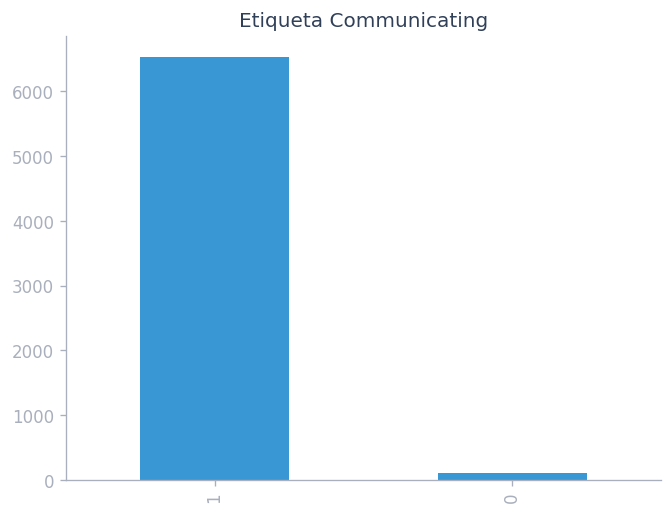

In [13]:
#Visualizando histograma mg_df
mg_df['Communicating'].value_counts().plot(kind='bar', title = "Etiqueta Communicating", color = mClr)

<AxesSubplot: title={'center': 'Etiqueta Communicating'}>

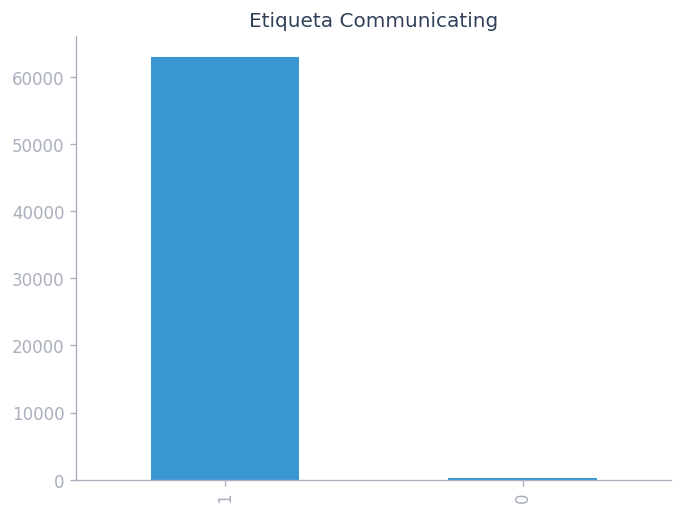

In [14]:
#Visualizando histograma mr_df
mr_df['Communicating'].value_counts().plot(kind='bar', title = "Etiqueta Communicating", color = mClr)

<AxesSubplot: title={'center': 'Etiqueta Communicating'}>

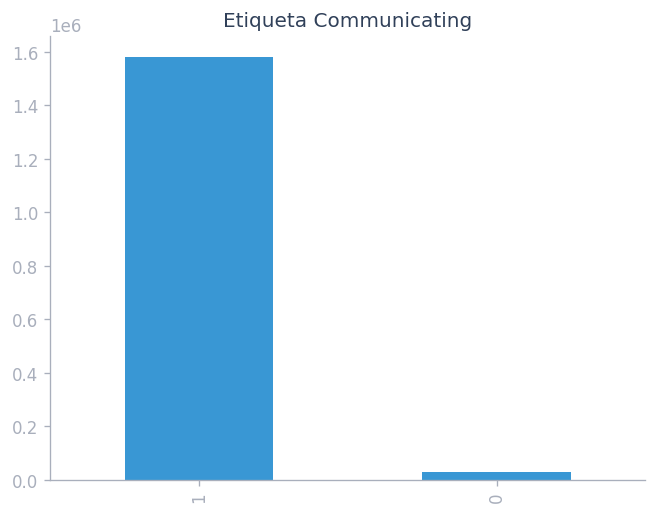

In [15]:
#Visualizando etiqueta mc_df
mc_df['Communicating'].value_counts().plot(kind='bar', title = "Etiqueta Communicating", color = mClr)

## Etiqueta Communicating 2

In [16]:
#Leyendo información de comando ping
mr_ping = pd.read_parquet("../../Data/DataMart/Views/Commands/MRPING.parquet")
mc_ping = pd.read_parquet("../../Data/DataMart/Views/Commands/MCPING.parquet")
rounds_df = pd.read_parquet("../../Data/DataMart/Base/roundsDf.parquet")

In [17]:
#Agregando información de ronda a ping
mr_ping['round'] = np.nan
mc_ping['round'] = np.nan
for i, row in rounds_df.iterrows():
    mask1 = (mr_ping["fDate"] >= row["fDate"]) & (mr_ping["fDate"] < row["lDate"])
    mask2 = (mc_ping["fDate"] >= row["fDate"]) & (mc_ping["fDate"] < row["lDate"])
    mr_ping.loc[mask1,"round"] = row["round"]
    mc_ping.loc[mask2,"round"] = row["round"]
#Vacíos en ronda
mr_ronda_empty = len(mr_ping[mr_ping['round'].isna()])
mc_ronda_empty = len(mc_ping[mc_ping['round'].isna()])
print(f"mr_ping: {mr_ronda_empty} mc_ping: {mc_ronda_empty}")

mr_ping: 695 mc_ping: 819


In [18]:
#Guardando vacíos para chequeo manual
mr_ping_empty = mr_ping[mr_ping['round'].isna()]
mc_ping_empty = mc_ping[mc_ping['round'].isna()]
mr_ping_empty.to_csv("../../Data/DataMart/temp/mr_ping_empty.csv", index=False)
mc_ping_empty.to_csv("../../Data/DataMart/temp/mc_ping_empty.csv", index=False)

In [19]:
#Eliminando vacíos por estar fuera del rango de tiempo
mr_ping = mr_ping[~mr_ping['round'].isna()]
mc_ping = mc_ping[~mc_ping['round'].isna()]
#Imprimiendo vacíos en ronda
mr_ronda_empty = len(mr_ping[mr_ping['round'].isna()])
mc_ronda_empty = len(mc_ping[mc_ping['round'].isna()])
print(f"mr_ping: {mr_ronda_empty} mc_ping: {mc_ronda_empty}")


mr_ping: 0 mc_ping: 0


In [20]:
#Eliminando columnas innecearias de ping
mr_ping.drop(columns=['commandType','commandLogId','TITLESTR','DCWSTR','addText','fName','fDate'], inplace=True)
mc_ping.drop(columns=['commandType','commandLogId','TITLESTR','DCWSTR','addText','fName','fDate'], inplace=True)

In [21]:
#Tratando duplicados en ping
total_mr_dups = len(mr_ping[mr_ping.duplicated(subset=['meterNo','round'])])
total_mc_dups = len(mc_ping[mc_ping.duplicated(subset=['meterNo','round'])])
print(f"mr_ping: {total_mr_dups} mc_ping: {total_mc_dups}")

mr_ping: 11563 mc_ping: 15922


In [22]:
#Guardando duplicados para chequeo manual
mr_ping_dups = mr_ping[mr_ping.duplicated(subset=['meterNo','round'], keep=False)]
mc_ping_dups = mc_ping[mc_ping.duplicated(subset=['meterNo','round'], keep=False)]
mr_ping_dups.to_csv("../../Data/DataMart/temp/mr_ping_dups.csv", index=False)
mc_ping_dups.to_csv("../../Data/DataMart/temp/mc_ping_dups.csv", index=False)


In [23]:
#Visualizando tamaño de dfs
print(f"mg_df: {mg_df.shape} mr_df: {mr_df.shape} mc_df: {mc_df.shape}")

mg_df: (6635, 18) mr_df: (63202, 19) mc_df: (1607261, 19)


In [24]:
#Convirtiendo a formato numérico
#mr_ping
mr_ping['DownstreamTime'] = mr_ping['DownstreamTime'].apply(lambda x: int(x) if x != None else np.nan)
mr_ping['UpstreamTime'] = mr_ping['UpstreamTime'].apply(lambda x: int(x) if x != None else np.nan)
mr_ping['TotalTime'] = mr_ping['TotalTime'].apply(lambda x: int(x) if x != None else np.nan)
mr_ping['DownstreamHops'] = mr_ping['DownstreamHops'].apply(lambda x: int(x) if x != None else np.nan)
mr_ping['UpstreamHops'] = mr_ping['UpstreamHops'].apply(lambda x: int(x) if x != None else np.nan)
mr_ping['TotalHops'] = mr_ping['TotalHops'].apply(lambda x: int(x) if x != None else np.nan)
#mc_ping
mc_ping['DownstreamTime'] = mc_ping['DownstreamTime'].apply(lambda x: int(x) if x != None else np.nan)
mc_ping['UpstreamTime'] = mc_ping['UpstreamTime'].apply(lambda x: int(x) if x != None else np.nan)
mc_ping['TotalTime'] = mc_ping['TotalTime'].apply(lambda x: int(x) if x != None else np.nan)
mc_ping['DownstreamHops'] = mc_ping['DownstreamHops'].apply(lambda x: int(x) if x != None else np.nan)
mc_ping['UpstreamHops'] = mc_ping['UpstreamHops'].apply(lambda x: int(x) if x != None else np.nan)
mc_ping['TotalHops'] = mc_ping['TotalHops'].apply(lambda x: int(x) if x != None else np.nan)

In [ ]:
#Agrupando mr
mr_final_ping = mr_ping.groupby(['meterNo','round']).agg({'cmStatus':lambda x: list(x),
                                                       'DownstreamTime': 'mean',
                                                       'UpstreamTime':'mean',
                                                       'TotalTime':'mean',
                                                       'DownstreamHops':'mean',
                                                       'UpstreamHops':'mean',
                                                       'TotalHops':'mean'
                                                       }).reset_index()

print(f"Tamaño mr_grouped: {mr_final_ping.shape}")
mr_final_ping.head()

In [ ]:
#Agrupando mc
mc_final_ping = mc_ping.groupby(['meterNo','round']).agg({'cmStatus':lambda x: list(x),
                                                       'DownstreamTime': 'mean',
                                                       'UpstreamTime':'mean',
                                                       'TotalTime':'mean',
                                                       'DownstreamHops':'mean',
                                                       'UpstreamHops':'mean',
                                                       'TotalHops':'mean'
                                                       }).reset_index()
print(f"Tamaño mc_grouped: {mc_final_ping.shape}")
mc_final_ping.head()

In [27]:
#Función de cálculo de proporción de comunicación
def com_proportion(cmStatus):
    total = len(cmStatus)
    success_count = cmStatus.count("Success")
    return success_count/total

In [28]:
#Asignando proporción de comunicación
mr_final_ping['comProportion'] = mr_final_ping['cmStatus'].apply(com_proportion)
mc_final_ping['comProportion'] = mc_final_ping['cmStatus'].apply(com_proportion)

In [29]:
#Eliminando cmStatus
mr_final_ping.drop(columns=['cmStatus'], inplace=True)
mc_final_ping.drop(columns=['cmStatus'], inplace=True)

In [30]:
#Visualizando valores únicos de comProportion
mr_comprop_values = mr_final_ping['comProportion'].unique()
mc_comprop_values = mc_final_ping['comProportion'].unique()
print(f"mr: {mr_comprop_values} mc: {mc_comprop_values}")

mr: [1.] mc: [1. 0.]


In [ ]:
#Agregando característica de comunicación 2 a dfs
temp_mr_df = mr_df.merge(mr_final_ping, on=['meterNo','round'], how='left')
temp_mc_df = mc_df.merge(mc_final_ping, on=['meterNo','round'], how='left')
temp_mc_df.head()

In [32]:
#Total de vacíos en comProportion
mr_comprop_empty = len(temp_mr_df[temp_mr_df['comProportion'].isna()])
mc_comprop_empty = len(temp_mc_df[temp_mc_df['comProportion'].isna()])
print(f"mr: {mr_comprop_empty} mc: {mc_comprop_empty}")

mr: 2546 mc: 969360


In [33]:
#Visualizando muestra de vacíos mc
mc_comprop_empty_df = temp_mc_df[temp_mc_df['comProportion'].isna()]
mc_comprop_empty_df.to_csv("../../Data/DataMart/temp/mc_comprop_empty.csv", index=False)

In [34]:
#Visualizando no vacíos
mc_comprop_not_empty_df = temp_mc_df[~temp_mc_df['comProportion'].isna()]
mc_comprop_not_empty_df.to_csv("../../Data/DataMart/temp/mc_comprop_not_empty.csv", index=False)

In [35]:
#Guardando ping para revisión manual
mr_final_ping.to_csv("../../Data/DataMart/temp/mr_ping.csv", index=False)
mc_final_ping.to_csv("../../Data/DataMart/temp/mc_ping.csv", index=False)
mr_final_ping.to_parquet("../../Data/DataMart/Views/DataViews/mc_ping.parquet")
mc_final_ping.to_parquet("../../Data/DataMart/Views/DataViews/mc_ping.parquet")

Se determinó la imposibilidad de utilizar los resultados del ping como etiqueta de comunicación. La razón principal es que en los registros de la base de datos existe una amplia cantidad de datos faltantes, mayor que la mitad. Por lo que se decide desechar esta característica y solo utilizar la que se calculó en función de los días sin comunicar.

In [36]:
#Shape de dfs
print(f"mg: {mg_df.shape} mr: {mr_df.shape} mc: {mc_df.shape}")

mg: (6635, 18) mr: (63202, 19) mc: (1607261, 19)


In [37]:
#Eliminando meterNo y radio
mg_df.drop(columns=['radio'], inplace=True)
mr_df.drop(columns=['meterNo','radio'], inplace=True)
mc_df.drop(columns=['meterNo','radio'], inplace=True)

In [38]:
#Shape de dfs
print(f"mg: {mg_df.shape} mr: {mr_df.shape} mc: {mc_df.shape}")

mg: (6635, 17) mr: (63202, 17) mc: (1607261, 17)


## Imputación de numberOfNeihghbors

In [39]:
#Asignando mejor vecino según path
mg_df['first_jump'] = mg_df['fixed_path'].apply(lambda x: x[0])
mr_df['first_jump'] = mr_df['fixed_path'].apply(lambda x: x[-2])
mc_df['first_jump'] = mc_df['fixed_path'].apply(lambda x: x[-2])

In [40]:
mg_df.drop('fDate', axis=1, inplace=True)
mr_df.drop('fDate', axis=1, inplace=True)
mc_df.drop('fDate', axis=1, inplace=True)

In [41]:
#Creando backup
mg_bk = mg_df.copy()
mr_bk = mr_df.copy()
mc_bk = mc_df.copy()

In [42]:
#Leyendo bk
#mg_df = mg_bk.copy()
#mr_df = mr_bk.copy()
#mc_df = mc_bk.copy()

In [43]:
#Agrupando por ronda para evitar redundancia mg
print(f"Shape mg:{mg_df.shape}")
#Convirtiendo columnas tipo lista para poder agrupar
mg_df['fixed_path'] = mg_df['fixed_path'].apply(lambda x: "|".join(x))
mg_df['FE-Comments'] = mg_df['FE-Comments'].apply(lambda x: "|".join(x))
#Agrupando
cols_for_grouping = ['serialNumber','CollectorNm','status','latitude','longitude','round','fixed_path','FE-Comments','first_jump','ImgName','cluster']
reduced_mg_df = mg_df.groupby(cols_for_grouping).agg({'NoCommunicatingDays':'mean',
                                                    'numberOfNeighbors':'mean',
                                                    'layer':'mean',
                                                    'DaysSinceLastStatusChanged':'mean',
                                                    'Communicating':'mean',
                                                    'path_length':'mean'
                                                    }).reset_index()
#Agregando columna tipo
reduced_mg_df['type'] = 'mg'
print(f"Shape mg:{reduced_mg_df.shape}")

Shape mg:(6635, 17)
Shape mg:(953, 18)


In [ ]:
#Regresando columnas a lista
reduced_mg_df['fixed_path'] = reduced_mg_df['fixed_path'].apply(lambda x: x.split("|"))
reduced_mg_df['FE-Comments'] = reduced_mg_df['FE-Comments'].apply(lambda x: x.split("|"))
reduced_mg_df.head()

In [45]:
#Agrupando por ronda para evitar redundancia mr
print(f"Shape mr:{mr_df.shape}")
#Convirtiendo columnas tipo lista para poder agrupar
mr_df['fixed_path'] = mr_df['fixed_path'].apply(lambda x: "|".join(x))
mr_df['FE-Comments'] = mr_df['FE-Comments'].apply(lambda x: "|".join(x))
#Agrupando
cols_for_grouping = ['serialNumber','CollectorNm','status','latitude','longitude','round','fixed_path','FE-Comments','first_jump','ImgName','cluster']
reduced_mr_df = mr_df.groupby(cols_for_grouping).agg({'NoCommunicatingDays':'mean',
                                                    'numberOfNeighbors':'mean',
                                                    'layer':'mean',
                                                    'DaysSinceLastStatusChanged':'mean',
                                                    'Communicating':'mean',
                                                    'path_length':'mean'
                                                    }).reset_index()
#Agregando columna tipo
reduced_mr_df['type'] = 'mr'
print(f"Shape mr:{reduced_mr_df.shape}")

Shape mr:(63202, 17)
Shape mr:(24103, 18)


In [ ]:
#Regresando columnas a lista
reduced_mr_df['fixed_path'] = reduced_mr_df['fixed_path'].apply(lambda x: x.split("|"))
reduced_mr_df['FE-Comments'] = reduced_mr_df['FE-Comments'].apply(lambda x: x.split("|"))
reduced_mr_df.head()

In [47]:
#Agrupando por ronda para evitar redundancia mc
print(f"Shape mc:{mc_df.shape}")
#Convirtiendo columnas tipo lista para poder agrupar
mc_df['fixed_path'] = mc_df['fixed_path'].apply(lambda x: "|".join(x))
mc_df['FE-Comments'] = mc_df['FE-Comments'].apply(lambda x: "|".join(x))
#Agrupando
cols_for_grouping = ['serialNumber','CollectorNm','status','latitude','longitude','round','fixed_path','FE-Comments','first_jump','ImgName','cluster']
reduced_mc_df = mc_df.groupby(cols_for_grouping).agg({'NoCommunicatingDays':'mean',
                                                    'numberOfNeighbors':'mean',
                                                    'layer':'mean',
                                                    'DaysSinceLastStatusChanged':'mean',
                                                    'Communicating':'mean',
                                                    'path_length':'mean'
                                                    }).reset_index()
#Agregando columna tipo
reduced_mc_df['type'] = 'mc'
print(f"Shape mc:{reduced_mc_df.shape}")

Shape mc:(1607261, 17)
Shape mc:(723807, 18)


In [ ]:
#Regresando columnas a lista
reduced_mc_df['fixed_path'] = reduced_mc_df['fixed_path'].apply(lambda x: x.split("|"))
reduced_mc_df['FE-Comments'] = reduced_mc_df['FE-Comments'].apply(lambda x: x.split("|"))
reduced_mc_df.head()

Se toma la decisión de diseño de asignar etiqueta de comunicación 1 a aquellos que tengan al menos un 0.9 en el valor de la variable, y 0 al resto.

In [49]:
#Modificando etiqueta 
reduced_mg_df['Communicating'] = reduced_mg_df['Communicating'].apply(lambda x: 1 if x>=0.9 else 0)
reduced_mr_df['Communicating'] = reduced_mr_df['Communicating'].apply(lambda x: 1 if x>=0.9 else 0)
reduced_mc_df['Communicating'] = reduced_mc_df['Communicating'].apply(lambda x: 1 if x>=0.9 else 0)
#Visualizando valores únicos de Communicating
mg_communicating_values = reduced_mg_df['Communicating'].unique()
mr_communicating_values = reduced_mr_df['Communicating'].unique()
mc_communicating_values = reduced_mc_df['Communicating'].unique()
print(f"mg: {mg_communicating_values} mr: {mr_communicating_values} mc: {mc_communicating_values}")

mg: [1 0] mr: [1 0] mc: [1 0]


<AxesSubplot: title={'center': 'Etiqueta Communicating - MG-Reduced'}>

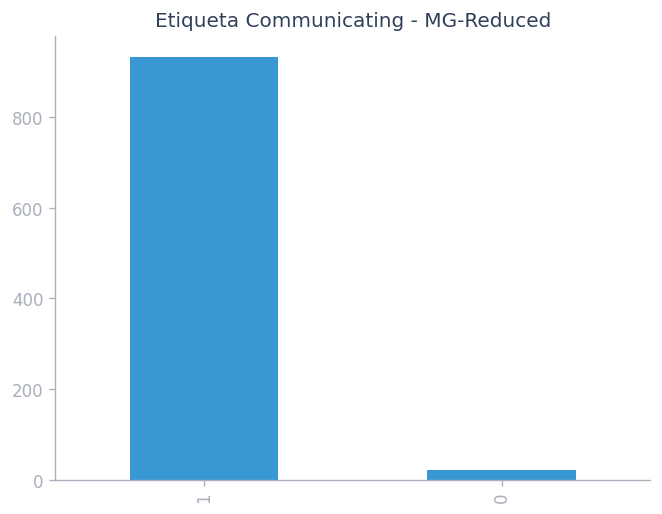

In [50]:
#Visualizando histograma para Communicating mg
reduced_mg_df['Communicating'].value_counts().plot(kind='bar', title = "Etiqueta Communicating - MG-Reduced", color = mClr)

<AxesSubplot: title={'center': 'Etiqueta Communicating -MR-Reduced'}>

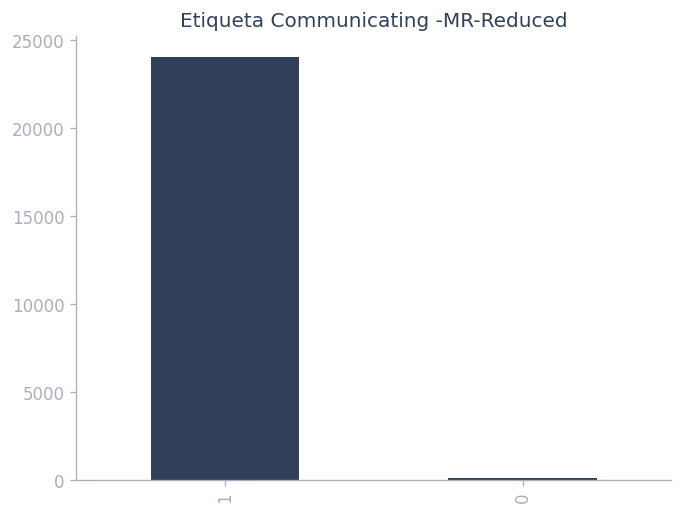

In [51]:
#Visualizando histograma para Communicating mr
reduced_mr_df['Communicating'].value_counts().plot(kind='bar', title = "Etiqueta Communicating -MR-Reduced", color = sClr3)

<AxesSubplot: title={'center': 'Etiqueta Communicating -MC-Reduced'}>

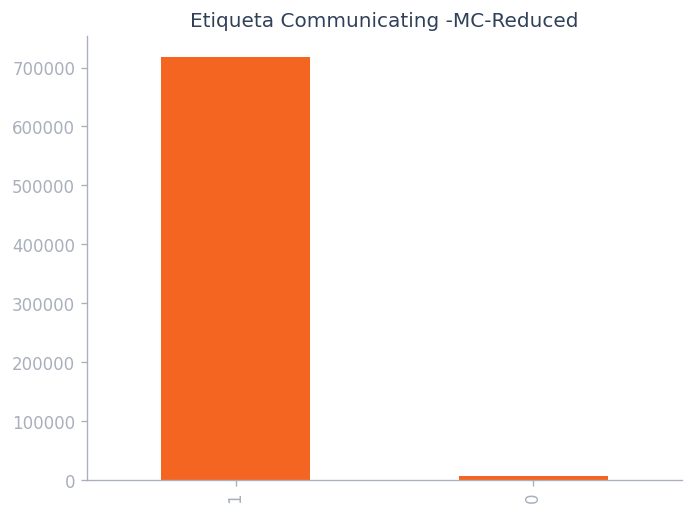

In [52]:
#Visualizando histograma para Communicating mc
reduced_mc_df['Communicating'].value_counts().plot(kind='bar', title = "Etiqueta Communicating -MC-Reduced", color = sClr1)

In [53]:
#bk2
mg_bk2 = reduced_mg_df.copy()
mr_bk2 = reduced_mr_df.copy()
mc_bk2 = reduced_mc_df.copy()


In [54]:
#Leyendo bk2
#reduced_mg_df = mg_bk2.copy()
#reduced_mr_df = mr_bk2.copy()
#reduced_mc_df = mc_bk2.copy()

In [55]:
#Visualizando columnas vacías
mg_empty = reduced_mg_df.columns[reduced_mg_df.isna().any()].tolist()
mr_empty = reduced_mr_df.columns[reduced_mr_df.isna().any()].tolist()
mc_empty = reduced_mc_df.columns[reduced_mc_df.isna().any()].tolist()
print(f"mg empty: {mg_empty}")
print(f"mr empty: {mr_empty}")
print(f"mc empty: {mc_empty}")

mg empty: ['numberOfNeighbors']
mr empty: ['numberOfNeighbors']
mc empty: ['numberOfNeighbors']


In [56]:
mg_emtpy_df = reduced_mg_df[reduced_mg_df['numberOfNeighbors'].isna()]
mr_emtpy_df = reduced_mr_df[reduced_mr_df['numberOfNeighbors'].isna()]
mc_emtpy_df = reduced_mc_df[reduced_mc_df['numberOfNeighbors'].isna()]

<AxesSubplot: title={'center': 'Histograma de vecinos - MG'}>

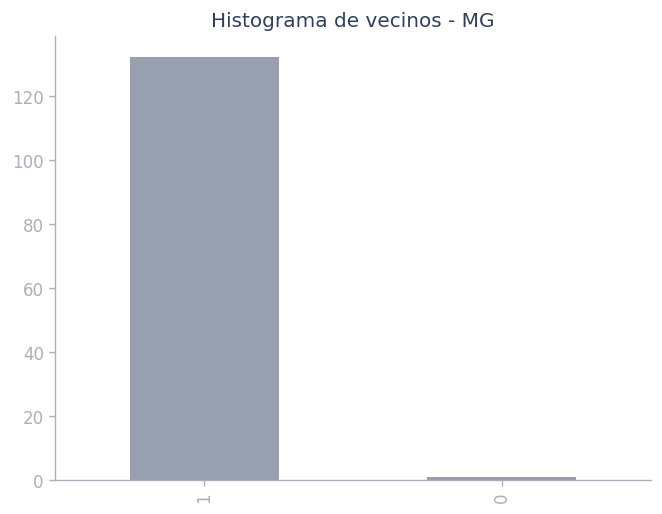

In [132]:
#Histograma mg
mg_emtpy_df['Communicating'].value_counts().plot(kind='bar', title = "Histograma de vecinos - MG", color = sClr2)

<AxesSubplot: title={'center': 'Histograma de vecinos - MR'}>

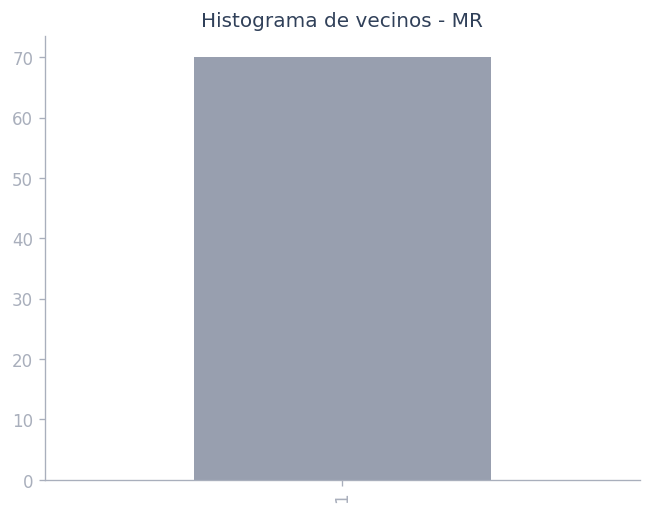

In [133]:
#Histograma mr
mr_emtpy_df['Communicating'].value_counts().plot(kind='bar', title = "Histograma de vecinos - MR", color = sClr2)

<AxesSubplot: title={'center': 'Histograma de vecinos - MC'}>

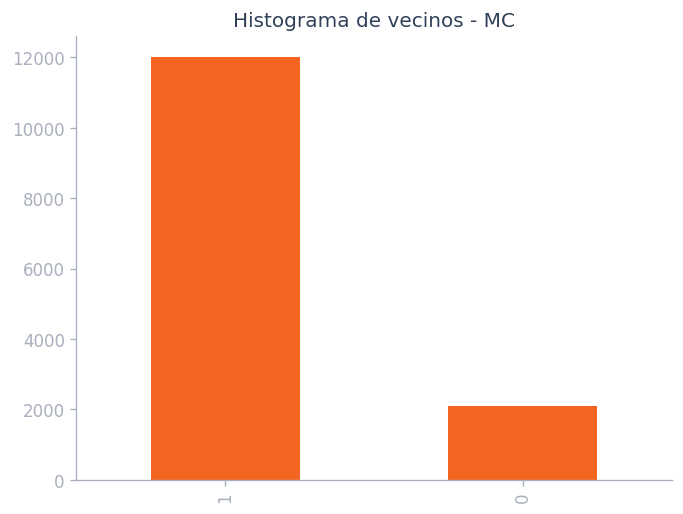

In [134]:
#Histograma mc
mc_emtpy_df['Communicating'].value_counts().plot(kind='bar', title = "Histograma de vecinos - MC", color = sClr1)

<AxesSubplot: title={'center': 'Histograma de No Comunica sin vecinos - MC'}, ylabel='Frequency'>

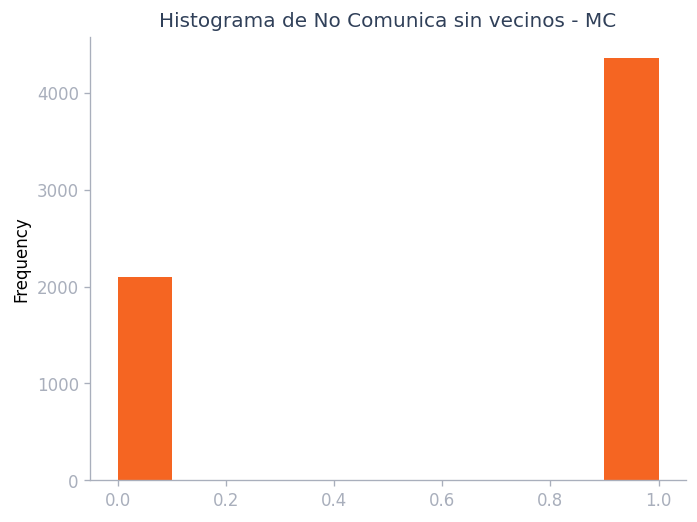

In [60]:
#Visualizando porción de NoCommunicatingDays sin vecinos
mc_nc = reduced_mc_df[reduced_mc_df['Communicating']==0]
#Histograma de NoCommunicatingDays sin vecinos
mc_nc['numberOfNeighbors'].apply(lambda x: 0 if math.isnan(x) else 1).plot(kind='hist', title = "Histograma de No Comunica sin vecinos - MC", color = sClr1)

<AxesSubplot: title={'center': 'Distribución de No Comunica con vecinos - MC'}, ylabel='Density'>

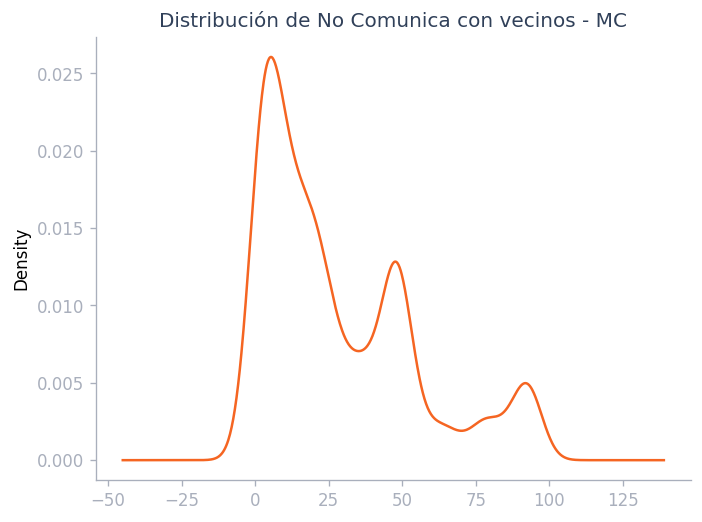

In [61]:
#Distribución de NoCommunicatingDays en mc no comunican
mc_nc['numberOfNeighbors'].plot(kind='kde', title = "Distribución de No Comunica con vecinos - MC", color = sClr1)

In [62]:
temp_color_map = plt.get_cmap('nr-d')
num_samples = 256
color_scale = [
    (i / (num_samples - 1), 
    matplotlib.colors.rgb2hex(temp_color_map(i / (num_samples - 1))))
    for i in range(num_samples)
]

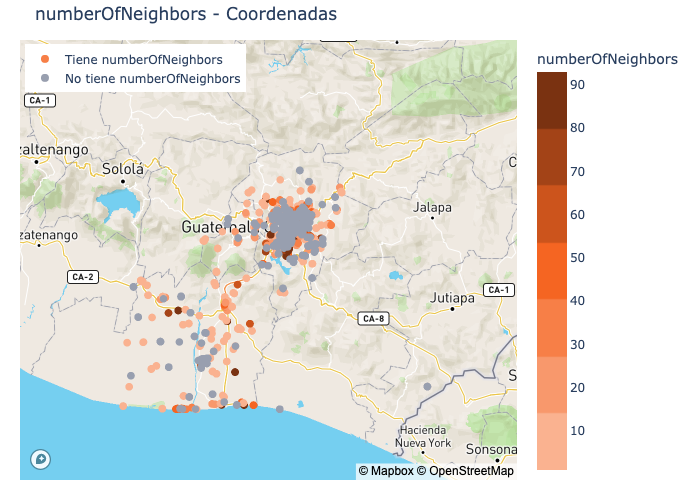

In [63]:
#Visualizando en dos dimensiones
mc_nc_wneigh = mc_nc[mc_nc['numberOfNeighbors'].notna()]
mc_nc_nneigh = mc_nc[mc_nc['numberOfNeighbors'].isna()]

fig = go.Figure()
#Mapa de calor
fig.add_trace(go.Scattermapbox(
                lat=mc_nc_wneigh['latitude'],
                lon=mc_nc_wneigh['longitude'],
                marker=dict(
                    size=8,
                    color=mc_nc_wneigh['numberOfNeighbors'],
                    colorscale=color_scale,
                    showscale=True,
                    colorbar=dict(title='numberOfNeighbors'),
                ),
                mode='markers',
                name='Tiene numberOfNeighbors',
                ))
#Mapa de puntos sin numberOfNeighbors
fig.add_trace(go.Scattermapbox(
                lat=mc_nc_nneigh['latitude'],
                lon=mc_nc_nneigh['longitude'],
                marker=dict(
                    size=8,
                    color=sClr2,
                ),
                mode='markers',
                name='No tiene numberOfNeighbors',
                ))

fig.update_layout(
    mapbox=dict(
        accesstoken=private_constants.mapbox_access_token,
        style='mapbox://styles/mapbox/streets-v11',
        center={"lat": mc_nc_wneigh['latitude'].mean(), "lon": mc_nc_wneigh['longitude'].mean()},
        zoom=7.5,
    ),
    margin={"r": 20, "t": 40, "l": 20, "b": 20},
    title="numberOfNeighbors - Coordenadas",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.update_layout(showlegend=True)
fig.show("png")

In [64]:
#Dividiendo datos
X = mc_nc_wneigh[['latitude','longitude']]
y = mc_nc_wneigh[['numberOfNeighbors']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#Seteando directorio de mlflow
import mlflow
from datetime import datetime
mlflow.set_tracking_uri("../mlruns")
mlflow.set_experiment("Imputación de vecinos-MC-NC")

In [96]:
from sklearn.model_selection import cross_val_score

#Dividiendo datos
X = mc_nc_wneigh[['latitude','longitude']]
y = mc_nc_wneigh[['numberOfNeighbors']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_neighbors = range(1, 30)

for k in n_neighbors:
    currentTime = currentTime = datetime.now().strftime(RUN_BASE_FORMAT)
    mlflow.start_run(run_name = currentTime)

    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Entrenar con el conjunto de entrenamiento
    knn.fit(X_train, y_train)
    
    # Evaluar en el conjunto de prueba
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    #Guardando k y métrica
    mlflow.log_param("k", k)
    mlflow.log_metric("mse", mse)
    mlflow.end_run()

In [135]:
#Obteniendo datos de ejecución
experiment_id = mlflow.get_experiment_by_name("Imputación de vecinos-MC-NC").experiment_id
runs = mlflow.search_runs(experiment_ids=experiment_id)

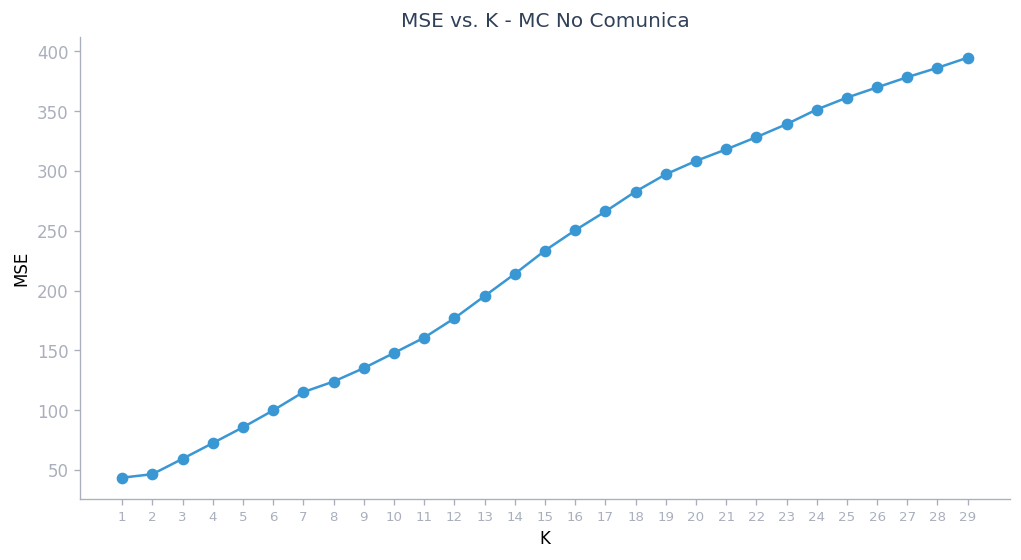

In [136]:
#Visualizando entrenamiento
runs["params.k"] = runs["params.k"].astype(int)
runs = runs.sort_values(by="params.k")
k_values = runs["params.k"]
mse = runs["metrics.mse"]
#Graficando mse
plt.figure(figsize=(10, 5))
plt.plot(k_values, mse, marker="o", color = mClr)
plt.title("MSE vs. K - MC No Comunica")
plt.xlabel("K")
plt.ylabel("MSE")
kticks = [i for i in k_values if i % 2 == 0]
plt.xticks(fontsize=8)
plt.xticks(k_values)
plt.show()

In [68]:
#Imputando con k=1
knn_nc = KNeighborsRegressor(n_neighbors=1)
knn_nc.fit(X, y)
mc_nc_nneigh['numberOfNeighbors'] = knn_nc.predict(mc_nc_nneigh[['latitude','longitude']])
print(f"numberOfNeighbors restantes sin imputar : {len(mc_nc_nneigh[mc_nc_nneigh['numberOfNeighbors'].isna()])}")
mc_nc_nneigh.head()

numberOfNeighbors restantes sin imputar : 0


,serialNumber,CollectorNm,status,latitude,longitude,round,fixed_path,FE-Comments,first_jump,ImgName,cluster,NoCommunicatingDays,numberOfNeighbors,layer,DaysSinceLastStatusChanged,Communicating,path_length,type
33288,1086560912,Sub Norte,Failed,14.66741170,-90.47797000,pData_1,"[2155807854, 2153896584, 1350214213, 135601747...",[Path imputed],1350043582,satImg-2523,5.00000000,22.50000000,1.00000000,11.12500000,22.50000000,0,7.00000000,mc
33289,1086560912,Sub Norte,Failed,14.66741170,-90.47797000,pData_10,"[2155807854, 2153896584, 1350214213, 135601747...",[Path imputed],1350043582,satImg-2523,5.00000000,86.00000000,1.00000000,21.28571429,86.00000000,0,7.00000000,mc
33290,1086560912,Sub Norte,Failed,14.66741170,-90.47797000,pData_11,"[2155807854, 2153896584, 1350214213, 135601747...",[Path imputed],1350043582,satImg-2523,5.00000000,93.00000000,1.00000000,12.14285714,93.00000000,0,7.00000000,mc
33291,1086560912,Sub Norte,Failed,14.66741170,-90.47797000,pData_12,"[2155807854, 2153896584, 1350214213, 135601747...",[Path imputed],1350043582,satImg-2523,5.00000000,99.50000000,1.00000000,6.83333333,99.50000000,0,7.00000000,mc
33292,1086560912,Sub Norte,Failed,14.66741170,-90.47797000,pData_2,"[2155807854, 2153896584, 1350214213, 135601747...",[Path imputed],1350043582,satImg-2523,5.00000000,30.00000000,1.00000000,11.28571429,30.00000000,0,7.00000000,mc


In [69]:
#Encontrando K óptimo para mg y mr
#Concatenando datos
mg_mr = pd.concat([reduced_mg_df[['serialNumber','latitude','longitude','numberOfNeighbors','FE-Comments']],\
                   reduced_mr_df[['serialNumber','latitude','longitude','numberOfNeighbors','FE-Comments']]], axis=0)
mg_mr_nneigh = mg_mr[mg_mr['numberOfNeighbors'].isna()]
mg_mr_wneigh = mg_mr[mg_mr['numberOfNeighbors'].notna()]

In [70]:
#Dividiendo datos
X1 = mg_mr_wneigh[['latitude','longitude']]
y1 = mg_mr_wneigh[['numberOfNeighbors']]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)


In [ ]:
#Seteando experimento
mlflow.set_experiment("Imputación de vecinos-MG-MR")

In [179]:
#Encontrando k óptimo
n_neighbors = range(1, 30)

for k in n_neighbors:
    currentTime = currentTime = datetime.now().strftime(RUN_BASE_FORMAT)
    mlflow.start_run(run_name = currentTime)

    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Entrenar con el conjunto de entrenamiento
    knn.fit(X_train1, y_train1)
    
    # Evaluar en el conjunto de prueba
    y_pred1 = knn.predict(X_test1)
    mse = mean_squared_error(y_test1, y_pred1)

    #Guardando k y métrica
    mlflow.log_param("k", k)
    mlflow.log_metric("mse", mse)
    mlflow.end_run()

In [72]:
#Obteniendo datos de ejecución
experiment_id = mlflow.get_experiment_by_name("Imputación de vecinos-MG-MR").experiment_id
runs = mlflow.search_runs(experiment_ids=experiment_id)

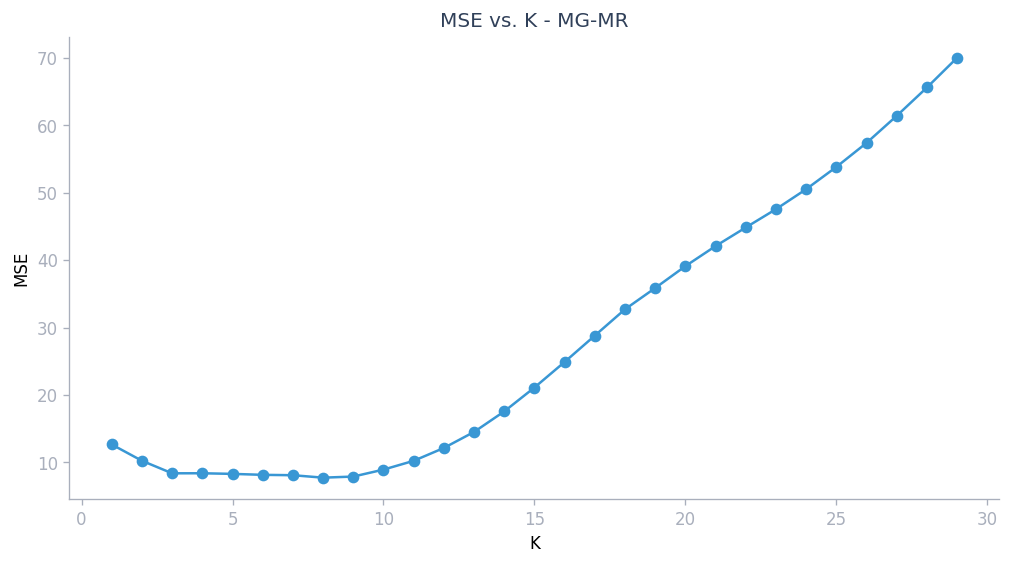

In [73]:
#Visualizando entrenamiento
runs.dropna(inplace=True)
runs["params.k"] = runs["params.k"].astype(int)
runs = runs.sort_values(by="params.k")
k_values = runs["params.k"]
mse = runs["metrics.mse"]
#Graficando mse
plt.figure(figsize=(10, 5))
plt.plot(k_values, mse, marker="o", color = mClr)
plt.title("MSE vs. K - MG-MR")
plt.xlabel("K")
plt.ylabel("MSE")
plt.show()

In [74]:
#Imputando knn con mejor k
bestK = runs.loc[runs['metrics.mse'].idxmin()]['params.k']
print(f"El major valor para K es: {bestK}")
knn_mg_mr = KNeighborsRegressor(n_neighbors=bestK)
knn_mg_mr.fit(X1, y1)
mg_mr_nneigh['numberOfNeighbors'] = knn_mg_mr.predict(mg_mr_nneigh[['latitude','longitude']])
print(f"numberOfNeighbors restantes sin imputar : {len(mg_mr_nneigh[mg_mr_nneigh['numberOfNeighbors'].isna()])}")

El major valor para K es: 8
numberOfNeighbors restantes sin imputar : 0


In [75]:
#Imputando en dfs
just_mg_nneigh = reduced_mg_df[reduced_mg_df['numberOfNeighbors'].isna()]
just_mr_nneigh = reduced_mr_df[reduced_mr_df['numberOfNeighbors'].isna()]
#Imputando
just_mg_nneigh['numberOfNeighbors'] = knn_mg_mr.predict(just_mg_nneigh[['latitude','longitude']])
just_mr_nneigh['numberOfNeighbors'] = knn_mg_mr.predict(just_mr_nneigh[['latitude','longitude']])
print(f"Vacíos en mg: {len(just_mg_nneigh[just_mg_nneigh['numberOfNeighbors'].isna()])}")
print(f"Vacíos en mr: {len(just_mr_nneigh[just_mr_nneigh['numberOfNeighbors'].isna()])}")

Vacíos en mg: 0
Vacíos en mr: 0


### Imputando para MC sí comunica

In [76]:
#Encontrando K óptimo para mc sí comunica
mc_c = reduced_mc_df[reduced_mc_df['Communicating']==1]
mc_c_nneigh = mc_c[mc_c['numberOfNeighbors'].isna()]
mc_c_wneigh = mc_c[mc_c['numberOfNeighbors'].notna()]
#Dividiendo datos
X2 = mc_c_wneigh[['latitude','longitude']]
y2 = mc_c_wneigh[['numberOfNeighbors']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [ ]:
#Seteando experimento
mlflow.set_experiment("Imputación de vecinos-MC-C")

In [173]:
#Encontrando k óptimo
n_neighbors = range(1, 30)

for k in n_neighbors:
    currentTime = currentTime = datetime.now().strftime(RUN_BASE_FORMAT)
    mlflow.start_run(run_name = currentTime)

    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Entrenar con el conjunto de entrenamiento
    knn.fit(X_train2, y_train2)
    
    # Evaluar en el conjunto de prueba
    y_pred2 = knn.predict(X_test2)
    mse = mean_squared_error(y_test2, y_pred2)

    #Guardando k y métrica
    mlflow.log_param("k", k)
    mlflow.log_metric("mse", mse)
    mlflow.end_run()

In [137]:
#Obteniendo datos de ejecución
experiment_id = mlflow.get_experiment_by_name("Imputación de vecinos-MC-C").experiment_id
runs = mlflow.search_runs(experiment_ids=experiment_id)

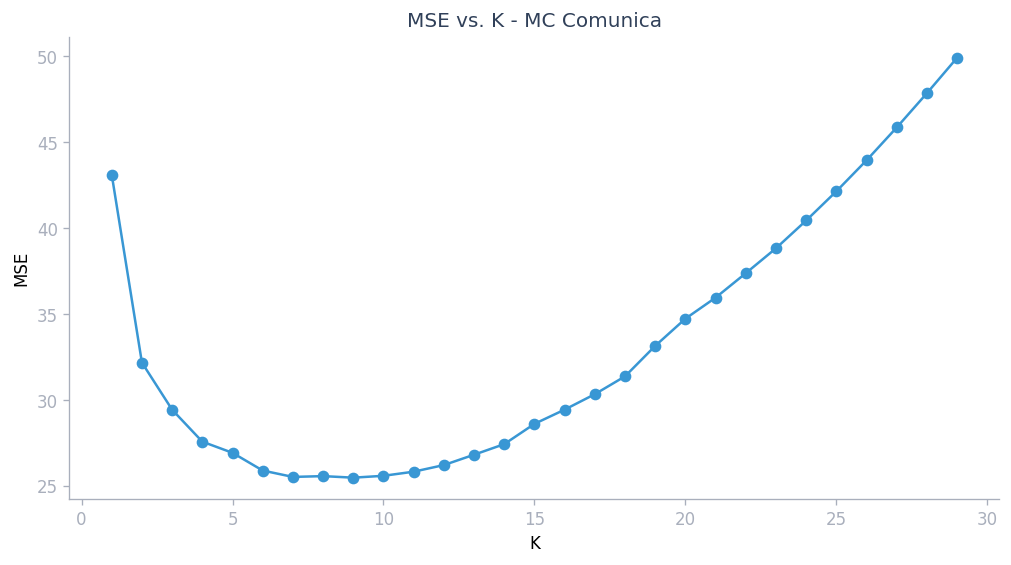

In [138]:
#Visualizando entrenamiento
runs.dropna(inplace=True)
runs["params.k"] = runs["params.k"].astype(int)
runs = runs.sort_values(by="params.k")
k_values = runs["params.k"]
mse = runs["metrics.mse"]
#Graficando mse
plt.figure(figsize=(10, 5))
plt.plot(k_values, mse, marker="o", color = mClr)
plt.title("MSE vs. K - MC Comunica")
plt.xlabel("K")
plt.ylabel("MSE")
plt.show()

In [80]:
#Imputando knn con mejor k
bestK = runs.loc[runs['metrics.mse'].idxmin()]['params.k']
print(f"El mejor valor para K es: {bestK}")
knn_mc_c = KNeighborsRegressor(n_neighbors=bestK)
knn_mc_c.fit(X2, y2)
mc_c_nneigh['numberOfNeighbors'] = knn_mc_c.predict(mc_c_nneigh[['latitude','longitude']])
print(f"numberOfNeighbors restantes sin imputar : {len(mc_c_nneigh[mc_c_nneigh['numberOfNeighbors'].isna()])}")

El mejor valor para K es: 9
numberOfNeighbors restantes sin imputar : 0


In [81]:
#Imputando en dfs principales
#Agregando FE-Comments
mc_nc_nneigh['FE-Comments'] = mc_nc_nneigh['FE-Comments'].apply(lambda x: x + ['numberON imputed'])
mc_c_nneigh['FE-Comments'] = mc_c_nneigh['FE-Comments'].apply(lambda x: x + ['numberON imputed'])
just_mg_nneigh['FE-Comments'] = just_mg_nneigh['FE-Comments'].apply(lambda x: x + ['numberON imputed'])
just_mr_nneigh['FE-Comments'] = just_mr_nneigh['FE-Comments'].apply(lambda x: x + ['numberON imputed'])

In [82]:
#Actualizando en dfs
#Imprimiendo vacíos
print(f"MG: {len(reduced_mg_df[reduced_mg_df['numberOfNeighbors'].isna()])} - MR: {len(reduced_mr_df[reduced_mr_df['numberOfNeighbors'].isna()])} - MC: {len(reduced_mc_df[reduced_mc_df['numberOfNeighbors'].isna()])}")
#Imputando
reduced_mg_df.update(just_mg_nneigh[['numberOfNeighbors','FE-Comments']])
reduced_mr_df.update(just_mr_nneigh[['numberOfNeighbors','FE-Comments']])
reduced_mc_df.update(mc_nc_nneigh[['numberOfNeighbors','FE-Comments']])
reduced_mc_df.update(mc_c_nneigh[['numberOfNeighbors','FE-Comments']])
#Imprimiendo vacíos e imputaciones
print(f"MG: {len(reduced_mg_df[reduced_mg_df['numberOfNeighbors'].isna()])} - MR: {len(reduced_mr_df[reduced_mr_df['numberOfNeighbors'].isna()])} - MC: {len(reduced_mc_df[reduced_mc_df['numberOfNeighbors'].isna()])}")
print(f"Imputados mg: {len(reduced_mg_df[reduced_mg_df['FE-Comments'].apply(lambda x: 'numberON imputed' in x)])}")
print(f"Imputados mr: {len(reduced_mr_df[reduced_mr_df['FE-Comments'].apply(lambda x: 'numberON imputed' in x)])}")
print(f"Imputados mc: {len(reduced_mc_df[reduced_mc_df['FE-Comments'].apply(lambda x: 'numberON imputed' in x)])}")


MG: 133 - MR: 70 - MC: 14100
MG: 0 - MR: 0 - MC: 0
Imputados mg: 133
Imputados mr: 70
Imputados mc: 14100


## Aumentando datos de No comunica

Se aprecia una clara asimetría entre las etiquetas de equipos que comunican y las de aquellos que no comunican. Por tal motivo se intentarán aumentar los datos de los equipos que no comunican, basádo en una idea sencilla. Si un equipo de la red no está comunicando con un determinado vecino, posiblemente imputado, tampoco comunicará con un vecino distinto, puesto que en caso contrario, el enlace se debió establecer de manera exitosa y la etiqueta de no comunica no sucedería.

In [83]:
#Comprobando columnas
mc_cols = reduced_mc_df.columns
mr_cols = reduced_mr_df.columns
#Comparando con diferencia simétrica
mr_diff = list(set(mc_cols) ^ set(mr_cols))
print(f"Columnas diferentes entre MR y MC: {mr_diff}")

Columnas diferentes entre MR y MC: []


Se determinó que en la imputación previa de Path existieron registros asignados que tenían el error de contener dentro del path imputado el serialNumber del equipo al que se imputaba. Esto debido a que en la cercanía existía la posibilidad de asignar como vecino a un equipo que utilizó en algún momento el salto hacia el equipo sin path.

In [84]:
#Corrigiendo paths inconsistentes
mr_bad_path = reduced_mr_df[reduced_mr_df.apply(lambda x: True if x['serialNumber'] in x['fixed_path'][:-1] else False, axis=1)]
mc_bad_path = reduced_mc_df[reduced_mc_df.apply(lambda x: True if x['serialNumber'] in x['fixed_path'][:-1] else False, axis=1)]
print(f"MR: {len(mr_bad_path)} MC: {len(mc_bad_path)}")

MR: 0 MC: 1027


In [85]:
mc_bad_path.to_csv("../../Data/DataMart/temp/mc_bad_path.csv")

In [86]:
#Imputando bad path
imputer_knn = NearestNeighbors(n_neighbors=1)
#Retirando índice de bad path
pool_df = reduced_mc_df[~reduced_mc_df.index.isin(mc_bad_path.index)]
for i, row in mc_bad_path.iterrows():
    temp_df = pool_df[pool_df['round'] == row['round']]
    temp_df = temp_df[temp_df.apply(lambda x: False if row['serialNumber'] in x['fixed_path'] else True, axis=1)]
    #Obteniendo vecino más cercano
    imputer_knn.fit(temp_df[['latitude','longitude']])
    distances, indices = imputer_knn.kneighbors([row[['latitude','longitude']].values], n_neighbors=1)
    best_neighbor = temp_df.iloc[indices[0][0]]
    #Imputando
    new_path = best_neighbor['fixed_path'] + [row['serialNumber']]
    mc_bad_path.loc[i,'fixed_path'] = "|".join(new_path)
    mc_bad_path.loc[i,'path_length'] = len(new_path)
    mc_bad_path.loc[i, 'first_jump'] = best_neighbor['serialNumber']
    #Imputando layer
    if 'Layer imputed' in row['FE-Comments']:
        mc_bad_path.loc[i,'layer'] = best_neighbor['layer'] + 1


In [ ]:
#Devolviendo fixed_path a lista
mc_bad_path['fixed_path'] = mc_bad_path['fixed_path'].apply(lambda x: x.split("|"))
mc_bad_path.head()

In [88]:
#Visualizando bad path remanente
mc_bad_path.to_csv("../../Data/DataMart/temp/mc_bad_path_fixed.csv")
mc_bad_path_fixed = mc_bad_path[mc_bad_path.apply(lambda x: True if x['serialNumber'] in x['fixed_path'][:-1] else False, axis=1)]
print(f"MC bad path restante: {len(mc_bad_path_fixed)}")

MC bad path restante: 0


In [ ]:
#Actualizando en df principal
reduced_mc_df.update(mc_bad_path[['fixed_path','path_length','first_jump','layer','FE-Comments']])
reduced_mc_df.head()

In [ ]:
#Creando df principal de equipos
equipos_df = pd.concat([reduced_mr_df, reduced_mc_df], axis=0)
print(f"Shape equipos: {equipos_df.shape}")
equipos_df.head()

In [92]:
#Seleccionando SN que solo tienen Communicating = 0
total_dev = equipos_df['serialNumber'].nunique()
dev_nc = equipos_df[equipos_df['Communicating']==0]['serialNumber'].unique()
dev_c = equipos_df[equipos_df['Communicating']==1]['serialNumber'].unique()
print(f"Total de equipos no comunican: {len(dev_nc)}, de {total_dev}.\nPorcentaje: {round(len(dev_nc)/total_dev*100,2)}%")
just_nc = set(dev_nc) - set(dev_c)
print(f"Equipos que nunca comunicaron: {len(just_nc)}. \nPorcentaje: {round(len(just_nc)/total_dev*100,2)}%")

Total de equipos no comunican: 764, de 20616.
Porcentaje: 3.71%
Equipos que nunca comunicaron: 232. 
Porcentaje: 1.13%


In [93]:
#Porcentaje de just_nc con numberOfNeighbors imputado
just_nc_df = equipos_df[equipos_df['serialNumber'].isin(just_nc)]
just_nc_imputed = just_nc_df[just_nc_df['FE-Comments'].apply(lambda x: 'numberON imputed' in x)]
#Imprimiendo
print(f"Registros que nunca comunicaron y fueron imputados: {len(just_nc_imputed)}. \nPorcentaje: {round(len(just_nc_imputed)/len(just_nc_df)*100,2)}%")

Registros que nunca comunicaron y fueron imputados: 1261. 
Porcentaje: 35.82%


<AxesSubplot: title={'center': 'Histograma de cantidad de registros con vecinos'}, ylabel='Frequency'>

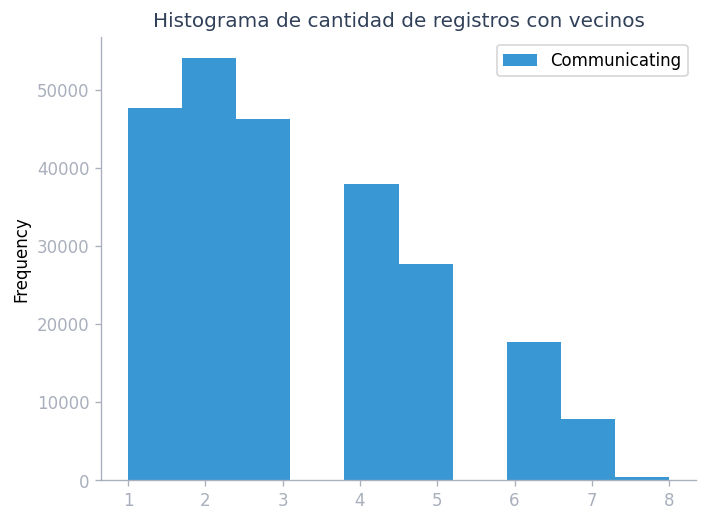

In [94]:
#Cantidad de vecinos sintéticos
#Histograma de cantidad de registros con vecinos
equipos_df.groupby(['serialNumber','round']).count().plot(kind='hist', y='Communicating', title = "Histograma de cantidad de registros con vecinos", color = mClr)

Como decisión de diseño, y por la costumbre de usar el sistema decimal, se generarán 10 muestras por cada ronda. La mitad de las mismas se mantendrá fija para acentuar comportamientos a través del tiempo. La otra mitad se generará de manera aleatoria. En ambos casos, se tomarán los datos de los 50 equipos más cercanos.

In [ ]:
#Ejemplo y visualización de datos sintéticos
knn_synthetic = NearestNeighbors(n_neighbors=50)

single_dev = random.sample(just_nc,1)[0]
single_dev_df = equipos_df[equipos_df['serialNumber']==single_dev]
single_dev_df = single_dev_df.sort_values(by='round')

single_round_df = single_dev_df[single_dev_df['round']=='pData_1']

all_jumps = single_round_df['first_jump'].unique()

to_select_df = equipos_df[(~equipos_df['first_jump'].isin(all_jumps+[single_dev])) & (equipos_df['round']=='pData_1')]

to_select_df = to_select_df[to_select_df['fixed_path'].apply(lambda x: False if single_dev in x else True)]

X = to_select_df[['latitude','longitude']]
knn_synthetic.fit(X)

#distances,indices = knn_synthetic.kneighbors(X)

distances, indices = knn_synthetic.kneighbors(single_round_df[['latitude','longitude']].reset_index(drop=True), n_neighbors=50)

#Df de vecinos
nearest_neighbors = to_select_df.iloc[indices[0]]

sample_df = nearest_neighbors.sample(10)
#nearest_neighbors = to_select_df.iloc[indices[0]]

syntetic_df_temp = pd.DataFrame(columns=equipos_df.columns)

base_row = single_round_df.iloc[0]

for index, row in sample_df.iterrows():
    current_row = base_row.copy()
    current_row['fixed_path'] = row['fixed_path'] + [single_dev]
    current_row['FE-Comments'] = row['FE-Comments'] + ['synthetic']
    current_row['layer'] = row['layer'] + 1
    current_row['CollectorNm'] = row['CollectorNm']
    current_row['first_jump'] = row['serialNumber']
    current_row['path_length'] = row['path_length'] + 1
    #Agregando row a df
    syntetic_df_temp = syntetic_df_temp.append(current_row)

syntetic_df_temp.head()

In [111]:
mapa_datos = {
    "NearestPoints" : {
        "color" : sClr2,
        "df" : nearest_neighbors,
        "coords" : ["latitude","longitude"],
        "size" : 15,
        "hover_field" : "serialNumber"
    },
    "SamplePoints" : {
        "color" : sClr1,
        "df" : sample_df,
        "coords" : ["latitude","longitude"],
        "size" : 15,
        "hover_field" : "serialNumber"
    },
    "SinglePoint" : {
        "color" : mClr,
        "df" : single_round_df,
        "coords" : ["latitude","longitude"],
        "size" : 15,
        "hover_field" : "serialNumber"
    }
}

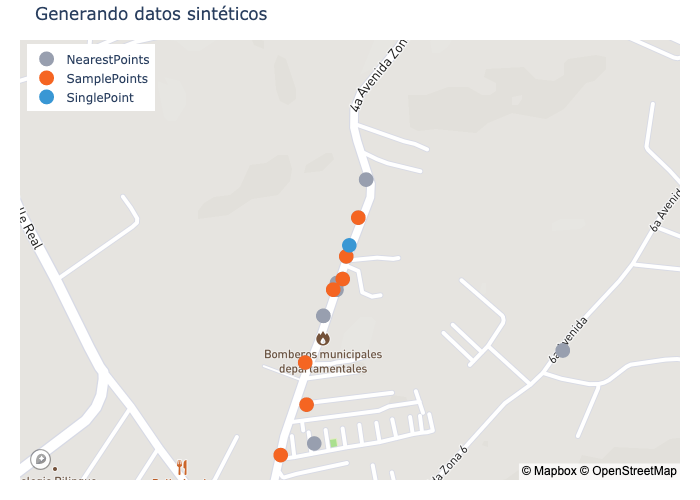

In [113]:
#Creando mapa
crear_mapa(mapa_datos, private_constants.mapbox_access_token, [nearest_neighbors['latitude'].mean(), nearest_neighbors['longitude'].mean()],\
           15, "Generando datos sintéticos", False)

In [117]:
#Generando todos los datos sintéticos
syntetic_df = pd.DataFrame(columns=equipos_df.columns)
knn_synthetic = NearestNeighbors(n_neighbors=50)
for dev in just_nc:
    single_dev_df = equipos_df[equipos_df['serialNumber']==dev]
    single_dev_df = single_dev_df.sort_values(by='round')
    for round in single_dev_df['round'].unique():
        single_round_df = single_dev_df[single_dev_df['round']==round]
        all_jumps = single_round_df['first_jump'].unique()
        to_select_df = equipos_df[(~equipos_df['serialNumber'].isin(all_jumps+[dev])) & (equipos_df['round']==round)]
        to_select_df = to_select_df[to_select_df['fixed_path'].apply(lambda x: False if dev in x else True)]
        X = to_select_df[['latitude','longitude']]
        knn_synthetic.fit(X)
        distances, indices = knn_synthetic.kneighbors(single_round_df[['latitude','longitude']].reset_index(drop=True), n_neighbors=50)
        nearest_neighbors = to_select_df.iloc[indices[0]]
        sample_df = nearest_neighbors.sample(10)
        base_row = single_round_df.iloc[0]
        for index, row in sample_df.iterrows():
            current_row = base_row.copy()
            current_row['fixed_path'] = row['fixed_path'] + [dev]
            current_row['FE-Comments'] = row['FE-Comments'] + ['synthetic']
            current_row['layer'] = row['layer'] + 1
            current_row['CollectorNm'] = row['CollectorNm']
            current_row['first_jump'] = row['serialNumber']
            current_row['path_length'] = row['path_length'] + 1
            #Agregando row a df
            syntetic_df = syntetic_df.append(current_row)

In [121]:
#Guardando datos sintéticos
syntetic_df.to_parquet("../../Data/DataMart/Views/DataViews/syntetic.parquet")
syntetic_df.to_csv("../../Data/DataMart/Views/DataViews/syntetic.csv", index=False)
print(f"Cantidad de registros sintéticos creados: {len(syntetic_df)}")

Cantidad de registros sintéticos creados: 25960


In [122]:
#Validando no autoreferencia en path
self_reference = syntetic_df.apply(lambda x: 1 if x['serialNumber'] in x['fixed_path'][:-1] else 0, axis=1)
print(f"Autoreferencias en path: {self_reference.sum()}")

Autoreferencias en path: 0


In [123]:
#Validando no autorefencia en path
temp_equipo_df = equipos_df.copy()
temp_equipo_df['self_reference'] = equipos_df.apply(lambda x: 1 if x['serialNumber'] in x['fixed_path'][:-1] else 0, axis=1)
print(f"Autoreferencias en path: {temp_equipo_df['self_reference'].sum()}")

Autoreferencias en path: 0


In [126]:
#Agregando datos sintéticos
print(f"Shape equipos: {equipos_df.shape}")
equipos_df = pd.concat([equipos_df, syntetic_df], axis=0, ignore_index=True)
print(f"Shape equipos: {equipos_df.shape}")

Shape equipos: (747910, 18)
Shape equipos: (773870, 18)


<AxesSubplot: title={'center': 'Histograma de etiqueta Communicating - Datos reales'}>

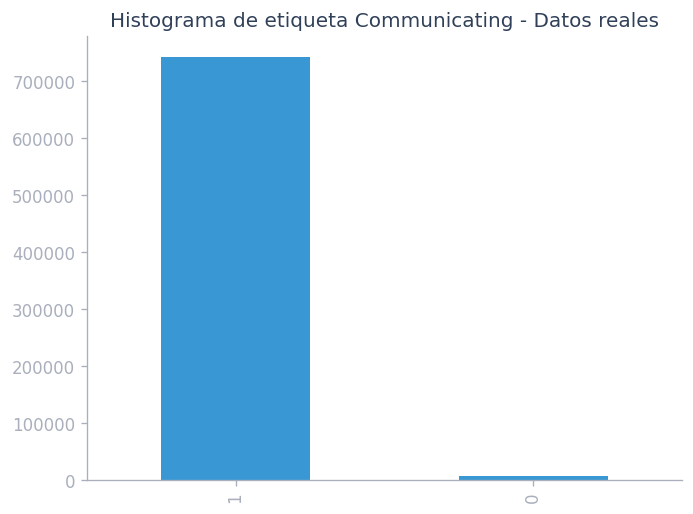

In [139]:
#Histograma de comunica y no comunica sin datos sintéticos
not_synthetic = equipos_df[equipos_df['FE-Comments'].apply(lambda x: 'synthetic' not in x)]
not_synthetic['Communicating'].value_counts().plot(kind='bar', title = "Histograma de etiqueta Communicating - Datos reales", color = mClr)

<AxesSubplot: title={'center': 'Histograma de etiqueta Communicating - Con sintéticos'}>

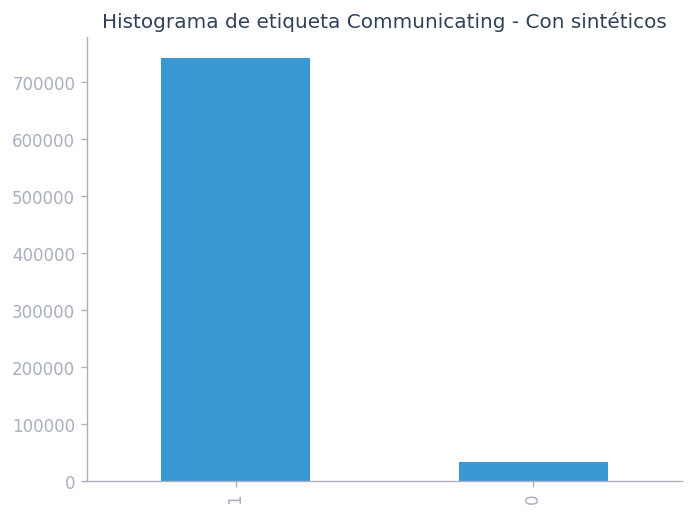

In [140]:
#Histograma de comunica y no comunica con sintéticos
equipos_df['Communicating'].value_counts().plot(kind='bar', title = "Histograma de etiqueta Communicating - Con sintéticos", color = mClr)

In [130]:
#Almacenando vistas en data mart views
#Parquet
reduced_mg_df.to_parquet("../../Data/DataMart/Views/DataViews/reduced_mg.parquet")
reduced_mr_df.to_parquet("../../Data/DataMart/Views/DataViews/reduced_mr.parquet")
reduced_mc_df.to_parquet("../../Data/DataMart/Views/DataViews/reduced_mc.parquet")
equipos_df.to_parquet("../../Data/DataMart/Views/DataViews/equipos.parquet")
syntetic_df.to_parquet("../../Data/DataMart/Views/DataViews/synthetic.parquet")
#CSV
reduced_mg_df.to_csv("../../Data/DataMart/Views/DataViews/reduced_mg.csv", index=False)
reduced_mr_df.to_csv("../../Data/DataMart/Views/DataViews/reduced_mr.csv", index=False)
reduced_mc_df.to_csv("../../Data/DataMart/Views/DataViews/reduced_mc.csv", index=False)
equipos_df.to_csv("../../Data/DataMart/Views/DataViews/equipos.csv", index=False)
syntetic_df.to_csv("../../Data/DataMart/Views/DataViews/synthetic.csv", index=False)